In [2]:
import pandas as pd
import folium

In [3]:
""" Helper functions"""
def label_timestamp (row) -> str:
	hour_of_day: int = row['timestamp'] % 24
	if 0 <= hour_of_day <= 8:
		return "00:00-08:00"
	elif 8 < hour_of_day <= 17:
		return "08:00-17:00"
	elif 17 < hour_of_day <= 20:
		return "17:00-20:00"
	else:
		return "20:00-00:00"

def label_day(row) -> str:
	day: int = int(row['timestamp'] / 24) % 7
	return "Weekend" if day >= 5 else "Workday"

def convert_hours_to_day_and_time(hours):
    hours = round(hours)
    days = hours // 24
    remaining_hours = hours % 24
    day_of_week = (days) % 7 
    time = f"{remaining_hours:02d}:00"
    day_mapping = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday"
    }
    return day_mapping[day_of_week], time

In [4]:
""" Load data """
queries = pd.read_csv('queries.csv', sep=" ")

In [5]:
queries['time_period'] = queries.apply(lambda row: label_timestamp(row), axis=1)
queries['day_type'] = queries.apply(lambda row: label_day(row), axis=1)

In [6]:
""" Grouped by IP address, day type, time period, latitude, longitude """
grouped_data = queries.groupby(["ip_address", "day_type", "time_period", "lat", "lon"]).agg({"timestamp": "count", "poi_type_query": lambda x: list(x.unique())})
grouped_data = grouped_data.reset_index()
grouped_data = grouped_data.rename(columns={"ip_address":"IP address", "day_type":"Day type", "time_period":"Time period", "lat":"Latitude", "lon":"Longitude", "timestamp":"Number of queries", "poi_type_query":"POI types queried"})
grouped_data.head(20)

,IP address,Day type,Time period,Latitude,Longitude,Number of queries,POI types queried
0,0.98.248.97,Weekend,08:00-17:00,46.510700,6.628843,5,"[cafeteria, restaurant, dojo]"
1,0.98.248.97,Weekend,08:00-17:00,46.513656,6.629130,1,[cafeteria]
2,0.98.248.97,Weekend,08:00-17:00,46.521057,6.648862,1,[dojo]
3,0.98.248.97,Weekend,08:00-17:00,46.521655,6.642749,1,[supermarket]
4,0.98.248.97,Weekend,08:00-17:00,46.524849,6.640184,1,[restaurant]
5,0.98.248.97,Weekend,08:00-17:00,46.532150,6.601756,1,[restaurant]
6,0.98.248.97,Weekend,08:00-17:00,46.544786,6.550837,1,[supermarket]
7,0.98.248.97,Weekend,08:00-17:00,46.545360,6.559572,1,[cafeteria]
8,0.98.248.97,Weekend,08:00-17:00,46.547491,6.554417,1,[restaurant]
9,0.98.248.97,Weekend,08:00-17:00,46.565231,6.564881,1,[dojo]


### User X

In [7]:
""" User X """
# IP address of the user we want to analyze
IP_ADDRESS = "146.71.112.211"
# Get all queries of user X
user_x = queries[queries["ip_address"]==IP_ADDRESS]
# Group by day type, time period, latitude, longitude
user_x = user_x.groupby(["day_type", "time_period", "lat", "lon"]).agg({"timestamp": "count", "poi_type_query": lambda x: list(x.unique())})
user_x = user_x.reset_index()
user_x = user_x.rename(columns={"day_type":"Day type", "time_period":"Time period", "lat":"Latitude", "lon":"Longitude", "timestamp":"Number of queries", "poi_type_query":"POI types queried"})
user_x.head(15)
# save latex table
# user_x.to_latex("user_x.tex", index=False)

,Day type,Time period,Latitude,Longitude,Number of queries,POI types queried
0,Weekend,08:00-17:00,46.509751,6.641607,1,[club]
1,Weekend,08:00-17:00,46.522632,6.564536,1,[dojo]
2,Weekend,08:00-17:00,46.526904,6.562937,1,[gym]
3,Weekend,08:00-17:00,46.529156,6.627356,4,"[supermarket, dojo, gym]"
4,Weekend,08:00-17:00,46.530865,6.623209,5,"[club, supermarket]"
5,Weekend,08:00-17:00,46.532748,6.628007,1,[supermarket]
6,Weekend,08:00-17:00,46.564457,6.566800,1,[gym]
7,Weekend,08:00-17:00,46.566729,6.550642,1,[gym]
8,Workday,08:00-17:00,46.535919,6.575488,30,"[cafeteria, restaurant]"
9,Workday,17:00-20:00,46.529156,6.627356,4,"[supermarket, gym, dojo]"


In [8]:
user_x = queries[queries["ip_address"]=="146.71.112.211"].groupby(["day_type", "time_period", "lat", "lon"])["poi_type_query"]
user_x.aggregate(lambda x: "{}-{}".format(len(list(x)),str(set(x))))

day_type  time_period  lat        lon     
Weekend   08:00-17:00  46.509751  6.641607                                   1-{'club'}
                       46.522632  6.564536                                   1-{'dojo'}
                       46.526904  6.562937                                    1-{'gym'}
                       46.529156  6.627356             4-{'dojo', 'gym', 'supermarket'}
                       46.530865  6.623209                    5-{'club', 'supermarket'}
                       46.532748  6.628007                            1-{'supermarket'}
                       46.564457  6.566800                                    1-{'gym'}
                       46.566729  6.550642                                    1-{'gym'}
Workday   08:00-17:00  46.535919  6.575488               30-{'cafeteria', 'restaurant'}
          17:00-20:00  46.529156  6.627356             4-{'dojo', 'gym', 'supermarket'}
                       46.530865  6.623209    20-{'club', 'dojo', 'gym', 'sup

<AxesSubplot: xlabel='day_type,time_period,lat,lon', ylabel='#Times the location occurs'>

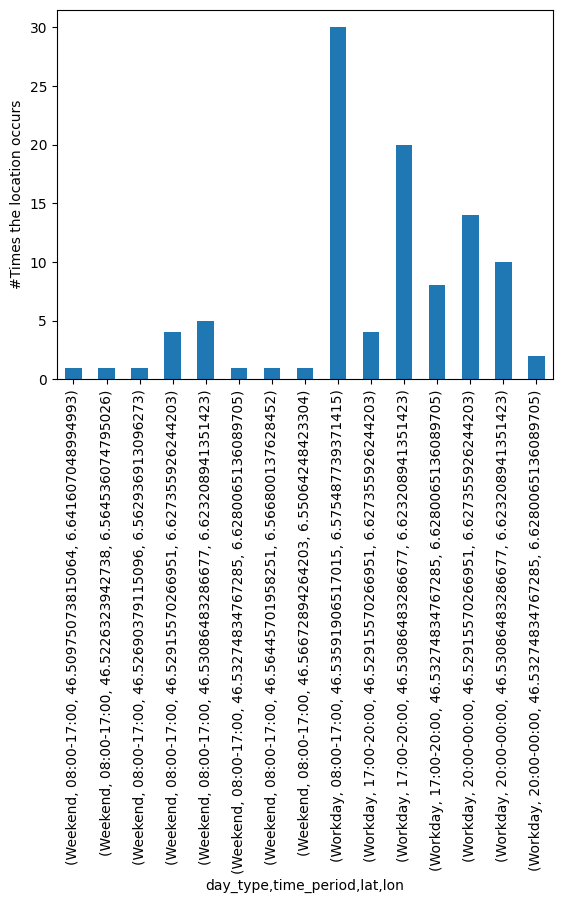

In [9]:
user_x.count().plot(kind = "bar", ylabel = "#Times the location occurs")

### Detailed analysis of User X

In [12]:
# IP address of the user we want to analyze
IP_ADDRESS = "146.71.112.211"

# Get all queries of user X
user_x = queries[queries["ip_address"]==IP_ADDRESS]

# convert hours to day and time
user_x["timestamp"] = user_x["timestamp"].apply(convert_hours_to_day_and_time)

# create map
map = folium.Map(location=[user_x['lat'].mean(), user_x['lon'].mean()], zoom_start=13)

# create a dictionary to store data for each location
timestamps_dict = {}
for index, row in user_x.iterrows():
    location = (row['lat'], row['lon'])
    timestamp = row['timestamp']
    poi_type_query = row['poi_type_query']

    day = timestamp[0]
    hour = timestamp[1]

    # custom filters 
    FILTER = "all"
    if FILTER == "work_hours":
        if day not in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
            continue
        if hour not in ["08:00", "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00"]:
            continue
    elif FILTER == "after_work":
        if day not in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
            continue
        if hour not in ["17:00", "18:00", "19:00", "20:00", "21:00", "22:00"]:
            continue
    elif FILTER == "weekend":
        if day not in ["Saturday", "Sunday"]:
            continue
    elif FILTER == "all":
        pass

    # add the timestamp to the dictionary for the corresponding location
    if location not in timestamps_dict:
        timestamps_dict[location] = []
    # format timestamp and POI type
    popup = "{}, {} - {}".format(day, hour, poi_type_query)
    timestamps_dict[location].append(popup)

# add markers to the map using the timestamps in the dictionary
for location, popups in timestamps_dict.items():
    iframe = folium.IFrame('<br>'.join(popups))
    popup = folium.Popup(iframe,
                     min_width=300,
                     max_width=300)
    marker = folium.Marker(location=location,
                       popup=popup).add_to(map)

# save map
map.save('map.html')

/tmp/ipykernel_186394/630197514.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_x["timestamp"] = user_x["timestamp"].apply(convert_hours_to_day_and_time)
